In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [157]:
import pandas as pd
import pickle
import numpy as np
from fastai.vision import *
from fastai.callbacks.hooks import *
import matplotlib.pyplot as plt
from lshash import lshash
from PIL import Image
from tqdm import tqdm_notebook
pd.set_option('display.max_columns', 500)

In [158]:
path = Path('caltech101/')

In [154]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [155]:
tfms = get_transforms(
    do_flip=False, 
    flip_vert=False, 
    max_rotate=0, 
    max_lighting=0, 
    max_zoom=1, 
    max_warp=0
)
data = (ImageList.from_folder(path)
        .random_split_by_pct(0.2)
        .label_from_folder()
        .transform(tfms=tfms, size=224)
        .databunch(bs=64))

C:\Users\sachj\Anaconda3\lib\site-packages\fastai\data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


TypeError: int() argument must be a string, a bytes-like object or a number, not '_NoValueType'

In [156]:
print('Number of classes {0}'.format(data.c))
print(data.classes)

NameError: name 'data' is not defined

In [14]:
print('Train dataset size: {0}'.format(len(data.train_ds.x)))
print('Test dataset size: {0}'.format(len(data.valid_ds.x)))

Train dataset size: 7316
Test dataset size: 1828


In [18]:
data.sanity_check

<bound method DataBunch.sanity_check of ImageDataBunch;

Train: LabelList (7316 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
accordion,accordion,accordion,accordion,accordion
Path: caltech101;

Valid: LabelList (1828 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Leopards,cougar_body,airplanes,elephant,garfield
Path: caltech101;

Test: None>

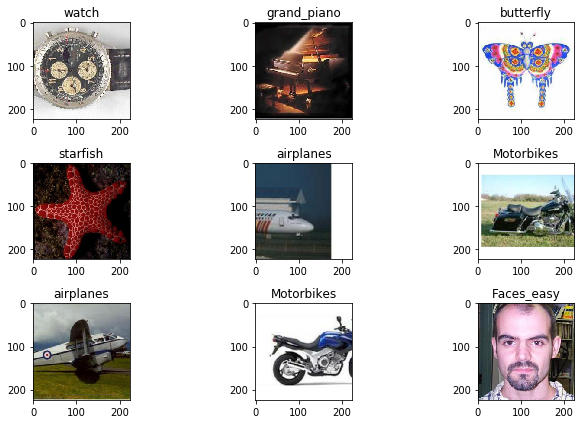

In [15]:
## Show sample data
data.show_batch(rows=3, figsize=(10,6), hide_axis=False)

In [16]:
## Creating the model
learn = create_cnn(data, models.resnet34, pretrained=True, metrics=accuracy)

C:\Users\sachj\Anaconda3\lib\site-packages\fastai\vision\learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [ ]:
## Finding Ideal learning late
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time


In [46]:
_= learn.get_preds(data.train_ds)

Exception ignored in: <function _ConnectionBase.__del__ at 0x000002001C8DD620>
Traceback (most recent call last):
  File "C:\Users\sachj\Anaconda3\lib\multiprocessing\connection.py", line 132, in __del__
    self._close()
  File "C:\Users\sachj\Anaconda3\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid


In [48]:
_= learn.get_preds(DatasetType.Valid)

In [50]:
img_path = [str(x) for x in (list(data.train_ds.items)+list(data.valid_ds.items))]
feature_dict = dict(zip(img_path,sf.features))

In [47]:
DatasetType.Valid

<DatasetType.Valid: 2>

In [51]:
pickle.dump(feature_dict, open(path/"feature_dict.p", "wb"))

In [20]:
## Loading Feature dictionary
feature_dict = pickle.load(open(path/'feature_dict.p','rb'))

In [22]:
## Locality Sensitive Hashing
# params
k = 10 # hash size
L = 5  # number of tables
d = 512 # Dimension of Feature vector
lsh = lshash.LSHash(hash_size=k, input_dim=d, num_hashtables=L)

# LSH on all the images
for img_path, vec in tqdm_notebook(feature_dict.items()):
    lsh.index(vec.flatten(), extra_data=img_path)

In [49]:
sf.features.shape

(9656, 512)

In [33]:
data.valid_ds[100][0].shape

torch.Size([3, 224, 224])

In [23]:
## Exporting as pickle
pickle.dump(lsh, open(path/'lsh.p', "wb"))

In [31]:
## Loading Feature dictionary
feature_dict = pickle.load(open(path/'feature_dict.p','rb'))
lsh = pickle.load(open(path/'lsh.p','rb'))

In [148]:
## Loading Feature dictionary
feature_dict = pickle.load(open(path/'feature_dict.p','rb'))
lsh = pickle.load(open(path/'lsh.p','rb'))

def get_similar_item(idx, feature_dict, lsh_variable, n_items=5):
    response = lsh_variable.query(feature_dict[list(feature_dict.keys())[idx]].flatten(), 
                     num_results=n_items+1, distance_func='hamming')
    
    columns = 3
    rows = int(np.ceil(n_items+1/columns))
    fig=plt.figure(figsize=(2*rows, 3*rows))
    for i in range(1, columns*rows +1):
        if i<n_items+2:
            img = Image.open(response[i-1][0][1])
            display(img)
            #print(img.shape)
            #fig.add_subplot(rows, columns, i)
            #plt.imshow(img)
    return plt.show()

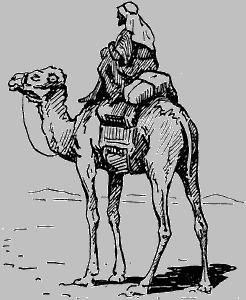

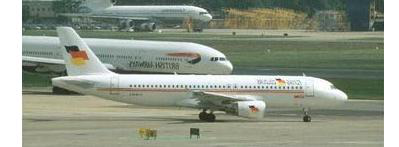

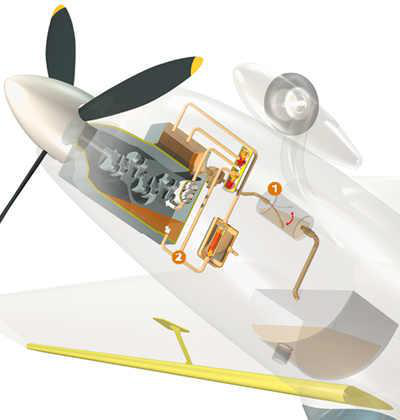

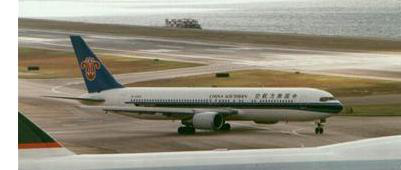

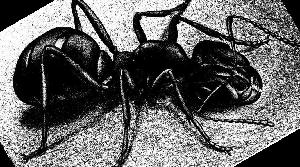

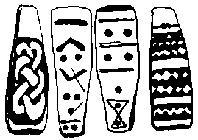

<Figure size 864x1296 with 0 Axes>

In [152]:
get_similar_item(1000, feature_dict, lsh,5)